In [1]:
from _tools import *
from _model_run import *
from os.path import join as pj
import matplotlib.pyplot as plt
import pickle
import xarray as xr

CUT_TO_PERIOD = True
MINIMUM_NUMBER_OF_OBSERVATIONS_IN_BASIN = 10
PERIOD = 'test'
RUN_DIR = pj(THIS_PROJECT_PATH,'runs')
DATA_SPLITTING_DIR = pj(PROJECT_DATA_CONFIG_PATH, 'per_basin')

### Load model runs

In [2]:
# Load the test period for each basin
with open(pj(DATA_SPLITTING_DIR, f'per_basin_{PERIOD}_periods_file.pkl'), 'rb') as f:
    periods_dict = pickle.load(f)
print(len(periods_dict))

570


In [3]:
loaded_runs:list[ModelRun]  = []
for model_run in os.listdir(RUN_DIR):
    if '_us_' in model_run:
        results_file = pj(RUN_DIR, model_run, PERIOD, 'model_epoch030', PERIOD + '_results.p')
        model = NeuralHydrology_USCAMELS_ModelRun(model_run, results_file, cut_to_period=CUT_TO_PERIOD)
        loaded_runs.append(model)
    else:
        pass
        # if '_qsim_' in model_run:
        #     continue
        results_file = pj(RUN_DIR, model_run, PERIOD, 'model_epoch030', PERIOD + '_results.p')
        model = NeuralHydrology_DKSUBSET_ModelRun(model_run, periods_dict=periods_dict, results_file=results_file, cut_to_period=CUT_TO_PERIOD)
        loaded_runs.append(model)


# model = DKHYPE_ModelRun(periods_dict=periods_dict, nc_file_folder=NC_FILES_FOLDER, cut_to_period=CUT_TO_PERIOD)
# loaded_runs.append(model)

model_runs = {model.label:model for model in loaded_runs}
model_runs

{'NSE LSTM ATTR PER BASIN 365': <_model_run.NeuralHydrology_DKSUBSET_ModelRun at 0x1dc6b09dbb0>,
 'NSE US LSTM ATTR 365': <_model_run.NeuralHydrology_USCAMELS_ModelRun at 0x1dc6bd601d0>}

### Filter results

In [4]:
must_exclude = []#['QSIM', 'EALSTM', 'KGE']
must_include = ['ATTR', 'NSE', '365']#['PER BASIN', 'NSE', 'ATTR']
# must_exclude = ['QSIM', 'EALSTM', 'KGE']
# must_include = ['PER BASIN', 'ATTR', 'NSE', '365']
must_at_least_include_either_or = []#['PER BASIN', 'US']

filtered_runs:dict[str, ModelRun] = {k: v for k, v in model_runs.items() if all([x in k for x in must_include]) and all([x not in k for x in must_exclude]) and (any([x in k for x in must_at_least_include_either_or]) if len(must_at_least_include_either_or) > 0 else True)}
# sort by len of name and last element which is integer
if 'DKHYPE' in filtered_runs.keys():
    del filtered_runs['DKHYPE']
filtered_runs = dict(sorted(filtered_runs.items(), key=lambda x: (len(x[0]))))
# filtered_runs = dict(sorted(filtered_runs.items(), key=lambda x: (x[0].split(' ')[0], int(x[0].split(' ')[-1]))))
# filtered_runs = dict(sorted(filtered_runs.items(), key=lambda x: (x[0].split(' ')[0], x[0].split(' ')[2], int(x[0].split(' ')[-1]))))
# filtered_runs['DKHYPE'] = model_runs['DKHYPE']
_ = [print(x) for x in filtered_runs.keys()]

NSE US LSTM ATTR 365
NSE LSTM ATTR PER BASIN 365


### Load results

In [5]:
for label, model in filtered_runs.items():
    model.load_results()

### Intersect basins across models

In [6]:
# Exclude these basins
exclude_basins = ['1000219', '1000228', '11000014', '11000060', '15001034', '16000130', '16000158', '16000258', '16000261', '16000273', '16000276', '16000410', '16000411', '16000649', '16000726', '16000777', '16001302', '16001334', '18000040', '18000079', '18000454', '18000887', '20000852', '21000455', '21000672', '21000760', '21001151', '21002451', '21002628', '21006071', '21006072', '21006206', '21006372', '21006375', '21006462', '21006597', '23000079', '24000034', '24000148', '24000149', '25000673', '25001085', '25001107', '25001149', '26000103', '26000114', '26000151', '32000019', '34000260', '34000469', '37000249', '38000019', '38000209', '38000221', '38000246', '38000250', '41000124', '41000129', '41000284', '41000695', '44000177', '47000422', '47000429', '47001025', '48000317', '49000090', '52000067', '55000444', '55000445', '56000070', '56000071', '56000073', '57000073', '57000494', '57001206', '9001110']

wrong_factor_basins = ['11000272', '16000726', '21000760', '21000782', '21000790', '25000642', '41000141', '45001337', '53000029', '6000428']

bad_basins = ['47000060', '47000061']

In [7]:
all_matching_basins = list(periods_dict.keys())
# Remove basins all_matching_basins that are present in exclude_basins
all_matching_basins = list(set(all_matching_basins).difference(exclude_basins))
# all_matching_basins = list(set(all_matching_basins).difference(wrong_factor_basins))
# all_matching_basins = list(set(all_matching_basins).difference(bad_basins))

# Intersect all basins in all runs
for label, model in filtered_runs.items():
    if ' US ' in label:
        continue
    all_matching_basins = list(set(all_matching_basins).intersection(model.filtered_basins))
    print(f'Name {model.label} - {len(all_matching_basins)}')



len(all_matching_basins)

Name NSE LSTM ATTR PER BASIN 365 - 494


494

### Set intersected basins for all models

In [8]:
# limit to only basins that are in all models
includes_us = False

tmp_df = pd.DataFrame(columns=['Basins', 'Filtered', 'No Observations'])
for label, model in filtered_runs.items():
    if ' US ' in label:
        model.filter_basins(model.all_basins)
    else:
        model.filter_basins(all_matching_basins)
    
    x = (len(model.all_basins), len(model.filtered_basins), len(model.no_observations_basins))
    tmp_df.loc[label] = x
    
tmp_df

,Basins,Filtered,No Observations
NSE US LSTM ATTR 365,531,531,0
NSE LSTM ATTR PER BASIN 365,570,494,61


### Calculate metrics

In [9]:
for model in filtered_runs.values():
    model.calculate_basin_metrics()

In [10]:
# Make a new pandas frame for each model as index and res.loc['mean'] as columns
res_df = pd.DataFrame()
for label, model in filtered_runs.items():
    df = model.get_metrics()
    res1 = df[['NSE','KGE','FBAL']].describe()
    res2 = df[df['CSI'] != -np.inf][['CSI']].describe()
    res = pd.concat([res1, res2], axis=1)
    # get count index row
    res.loc['count']
    res_df[label] = res.loc['mean']
    # if '365' in label:
    #     print(label)
    #     display(res)
res_df = res_df.T
res_df.reset_index(inplace=True)    
res_df.rename(columns={'index':'Model'}, inplace=True)
table = res_df.copy()
table['Loss'] = [x.split(' ')[0] for x in table['Model'].values]
table['Seq Len.'] = [x.split(' ')[-1] for x in table['Model'].values]
table['Static Attr.'] = ['Y' if 'ATTR' in x else 'N' for x in table['Model'].values]
table['Qsim'] = ['Y' if 'QSIM' in x else 'N' for x in table['Model'].values]
# Reorder columns
table = table[['Model', 'Loss', 'Seq Len.', 'Static Attr.','Qsim', 'NSE', 'KGE', 'FBAL', 'CSI']]
# Remove loss and seq len and static attr from model name
table['Model'] = [x.replace('NSE ', '').replace('MSE ', '').replace(' ATTR ', ' ').replace(' 365', ' ').replace(' 30', ' ').replace(' 90', ' ').replace(' PER BASIN ', ' ').replace(' QSIM ', ' ') for x in table['Model'].values]
# order by, then by
table = table.sort_values(by=['Loss','Static Attr.'])
display(res_df.head())
display(table)
print(table.to_latex(index=False, float_format="%.2f", label='tab:metrics_table', caption='Metrics table for all models'))

,Model,NSE,KGE,FBAL,CSI
0,NSE US LSTM ATTR 365,0.372017,0.624104,11.431547,0.450525
1,NSE LSTM ATTR PER BASIN 365,-0.916343,0.705691,-1.374411,0.349057


,Model,Loss,Seq Len.,Static Attr.,Qsim,NSE,KGE,FBAL,CSI
0,US LSTM,NSE,365,Y,N,0.372017,0.624104,11.431547,0.450525
1,LSTM,NSE,365,Y,N,-0.916343,0.705691,-1.374411,0.349057


\begin{table}
\caption{Metrics table for all models}
\label{tab:metrics_table}
\begin{tabular}{lllllrrrr}
\toprule
Model & Loss & Seq Len. & Static Attr. & Qsim & NSE & KGE & FBAL & CSI \\
\midrule
US LSTM  & NSE & 365 & Y & N & 0.37 & 0.62 & 11.43 & 0.45 \\
LSTM  & NSE & 365 & Y & N & -0.92 & 0.71 & -1.37 & 0.35 \\
\bottomrule
\end{tabular}
\end{table}



In [12]:
# # plot KGE and FBAL as points for each model
# fig, ax = plt.subplots(figsize=(12, 8))
# for i, row in table.iterrows():
#     if row['Model'] == 'DKHYPE':
#         continue
#     color_dict = {'30': 'blue', '365': 'red', '90': 'green'}
#     ax.scatter(row['KGE'], row['FBAL'], label=row['Model'], color=color_dict[row['Seq Len.']])
#     ax.annotate(row['Model'], (row['KGE'], row['FBAL']))
# ax.set_xlabel('KGE')
# ax.set_ylabel('FBAL')
# plt.legend()

### Load the dataframes

In [11]:
# Helper function to get color based on regex patterns in the name
def get_color_by_regex(name):
    regex_color_map = [
        (r'.*90.*', 'red'),
        (r'.*30.*', 'blue'),
        (r'.*365.*', 'green'),

        # (r'MSE.*', 'red'),
        # (r'NSE.*', 'blue'),
        # (r'KGE.*', 'green'),
    ]
    # Fallback color for names that don't match any pattern
    fallback_color = 'gray'
    
    for pattern, color in regex_color_map:
        if re.search(pattern, name):
            return color
    return fallback_color  # Return fallback color if no pattern matches

# show the color mapping
# fig, ax = plt.subplots(figsize=(10, 5))
# for i, name in enumerate(filtered_runs.keys()):
#     color = get_color_by_regex(name)
#     ax.plot(i, 0, marker='o', markersize=10, color=color, label=name, linestyle='None')
# ax.legend(loc='center', ncol=2)
# ax.axis('off')
# plt.show()

def add_subplot(ax, metric, xlim=None, include_DKHYPE=False):
    model_metrics = {name: model.get_metrics()[metric].values for name, model in filtered_runs.items()}

    unique_names = set([x.split(' ')[-1] for x in model_metrics.keys()])
    counter = {x: 0 for x in unique_names}
    for name, metrics in model_metrics.items():
        loss_model = name.split(' ')[-1]
        metrics.sort()
        color = get_color_by_regex(name)
        linestyle = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10)), (0, (5,10))]
        if 'DKHYPE' in name:
            if include_DKHYPE:
                ax.ecdf(metrics, alpha=0.7, label=f'{name} - {len(metrics)}', linewidth=2, linestyle='solid', color='black')
        else:
            try:
                ax.ecdf(metrics, alpha=0.7, label=f'{name} - {len(metrics)}', linewidth=2)#, linestyle=linestyle[counter[loss_model]  % len(linestyle)], color=color)
            except Exception as e:
                print(name)
                print(e)
                
        counter[loss_model] += 1
        
    ax.legend()
    ax.set_title(f"{metric} CDF")
    ax.set_xlabel(metric)
    ax.set_ylabel("CDF")
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    ax.grid()
    ax.set_yticks(np.arange(0, 1.1, 0.1))

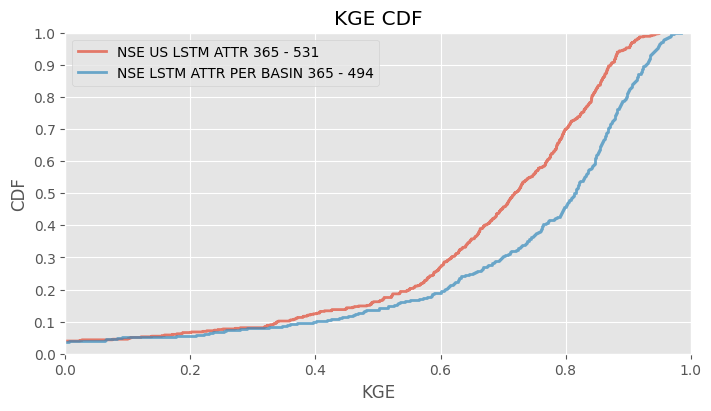

In [28]:
plt.style.use('ggplot')  
fig, ax = plt.subplots(1,1, figsize=(7,4), layout='constrained')
xlim = (0.0, 1.0)
# xlim = None
include_DKHYPE = False

add_subplot(ax, metric='KGE', xlim=xlim, include_DKHYPE=include_DKHYPE)

# plt.suptitle("Model Performance Metrics")
# plt.xscale('log')
plt.grid()
plt.savefig(pj(PROJECT_FIGURES_PATH, "cdf_kge_us_vs_dk.png"), dpi=150)
plt.show()

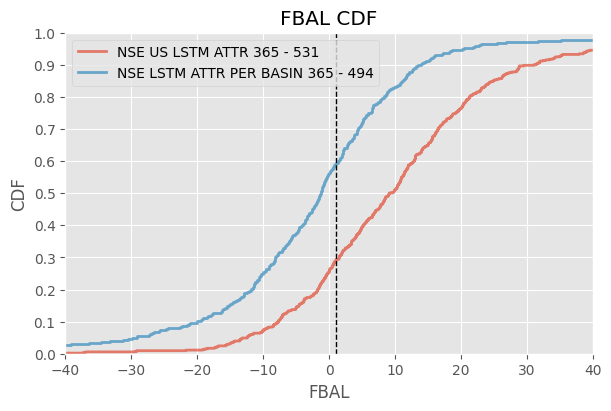

In [29]:
plt.style.use('ggplot')  
fig, ax = plt.subplots(1,1, figsize=(6,4), layout='constrained')
xlim = (-40, 40)
# xlim=None
include_DKHYPE = False
metric = 'FBAL'

add_subplot(ax, metric=metric, xlim=xlim, include_DKHYPE=include_DKHYPE)
# Add vertical line at 0
ax.axvline(1, color='black', linestyle='--', linewidth=1)

# plt.suptitle("Model Performance Metrics")
# plt.xscale('log')
plt.grid()
plt.savefig(pj(PROJECT_FIGURES_PATH, f"cdf_fbal_us_vs_dk.png"), dpi=150)
plt.show()

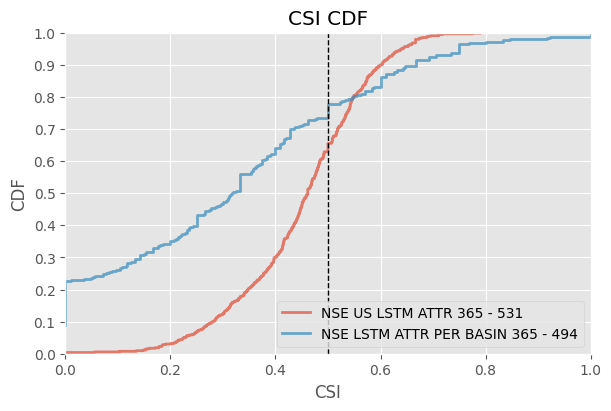

In [30]:
plt.style.use('ggplot')  
fig, ax = plt.subplots(1,1, figsize=(6,4), layout='constrained')
xlim = (0, 1)
# xlim=None
include_DKHYPE = True
metric = 'CSI'

add_subplot(ax, metric=metric, xlim=xlim, include_DKHYPE=include_DKHYPE)
# Add vertical line at 0
ax.axvline(.5, color='black', linestyle='--', linewidth=1)

# plt.suptitle("Model Performance Metrics")
# plt.xscale('log')
plt.grid()
plt.savefig(pj(PROJECT_FIGURES_PATH, f"cdf_csi_us_vs_dk.png"), dpi=150)
plt.show()

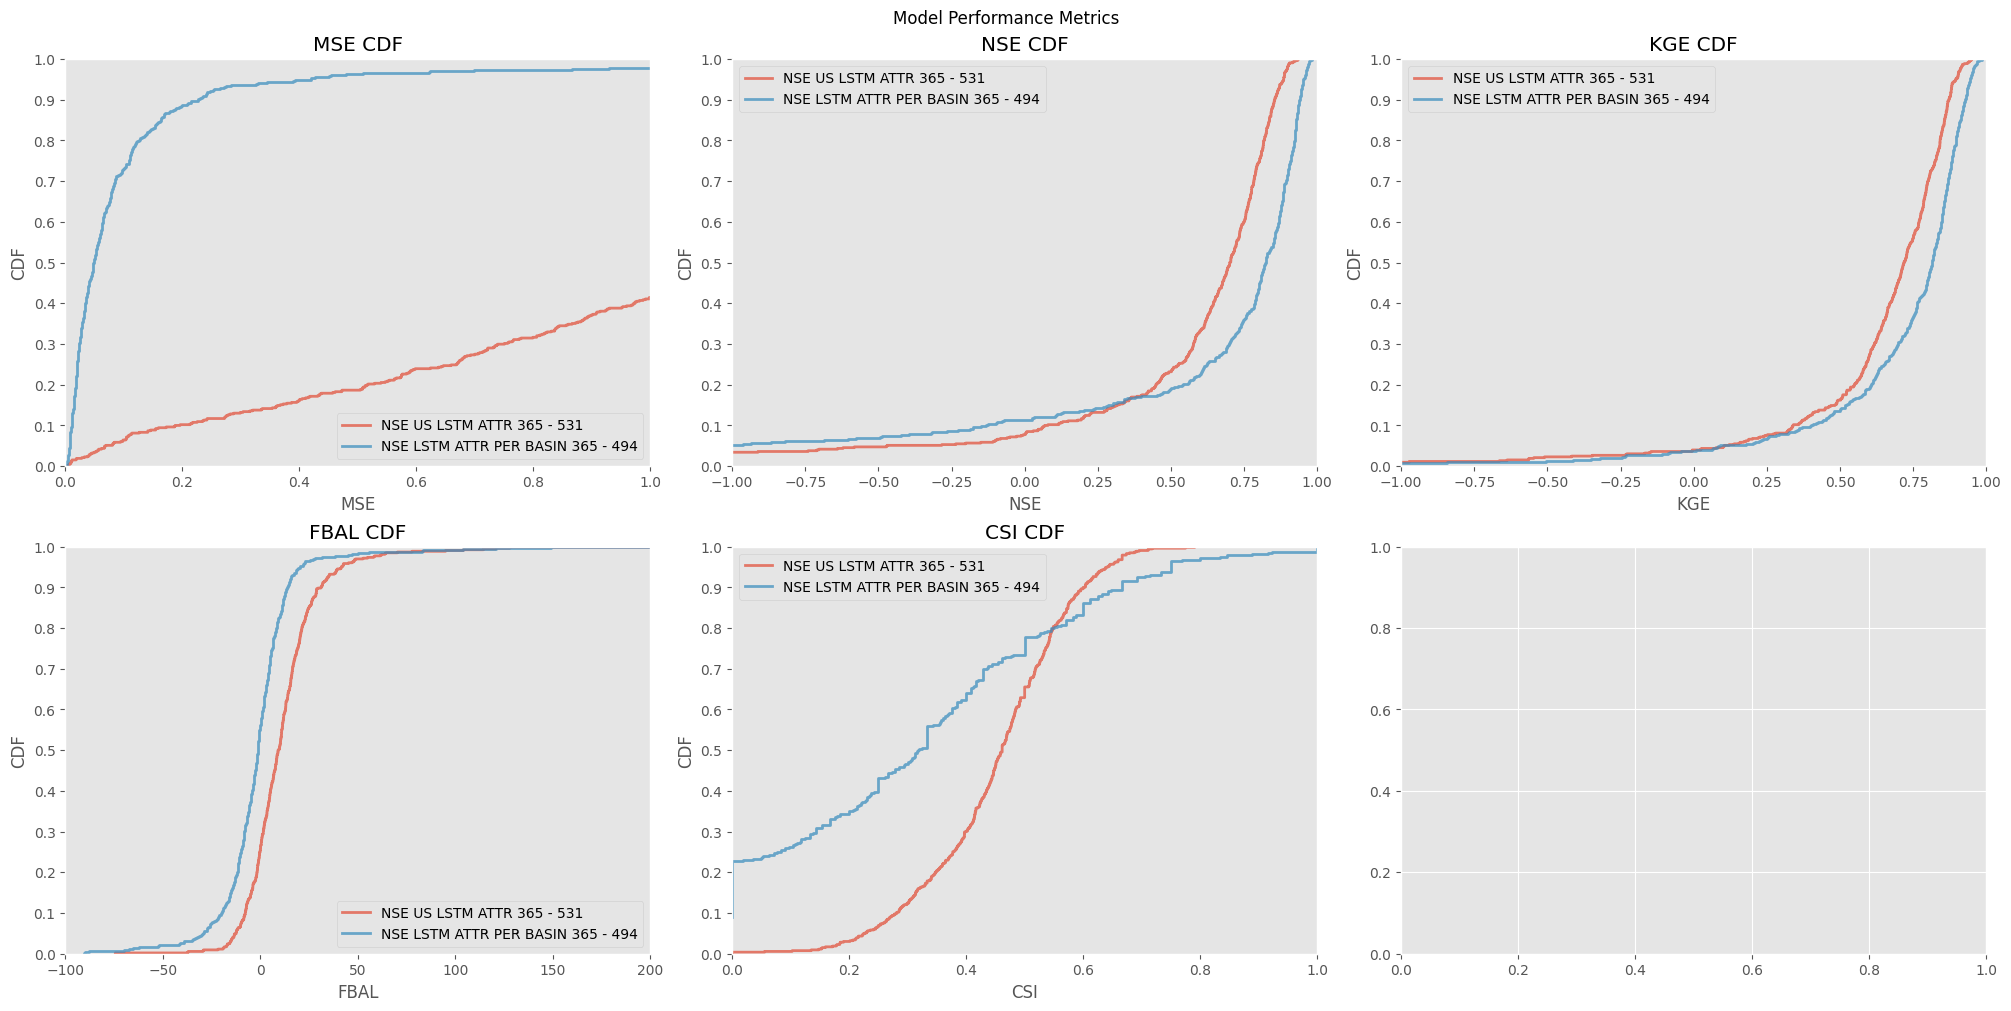

In [31]:
plt.style.use('ggplot')  
fig, ax = plt.subplots(2,3, figsize=(20,10), layout='constrained')
xmin = -1.0
include_DKHYPE = False
add_subplot(ax[0,0], 'MSE', xlim=(0.0, 1.0), include_DKHYPE=include_DKHYPE)
add_subplot(ax[0,1], 'NSE', xlim=(-1.0, 1.0), include_DKHYPE=include_DKHYPE)
add_subplot(ax[0,2], 'KGE', xlim=(-1.0, 1.0), include_DKHYPE=include_DKHYPE)
add_subplot(ax[1,0], 'FBAL', xlim=(-100, 200), include_DKHYPE=include_DKHYPE)
add_subplot(ax[1,1], 'CSI', xlim=(0, 1), include_DKHYPE=include_DKHYPE)

plt.suptitle("Model Performance Metrics")
# plt.savefig(pj(PROJECT_FIGURES_PATH, "cdf_model_performance.png"), dpi=600)
plt.show()

## LSTM including DKHYPE discharge 

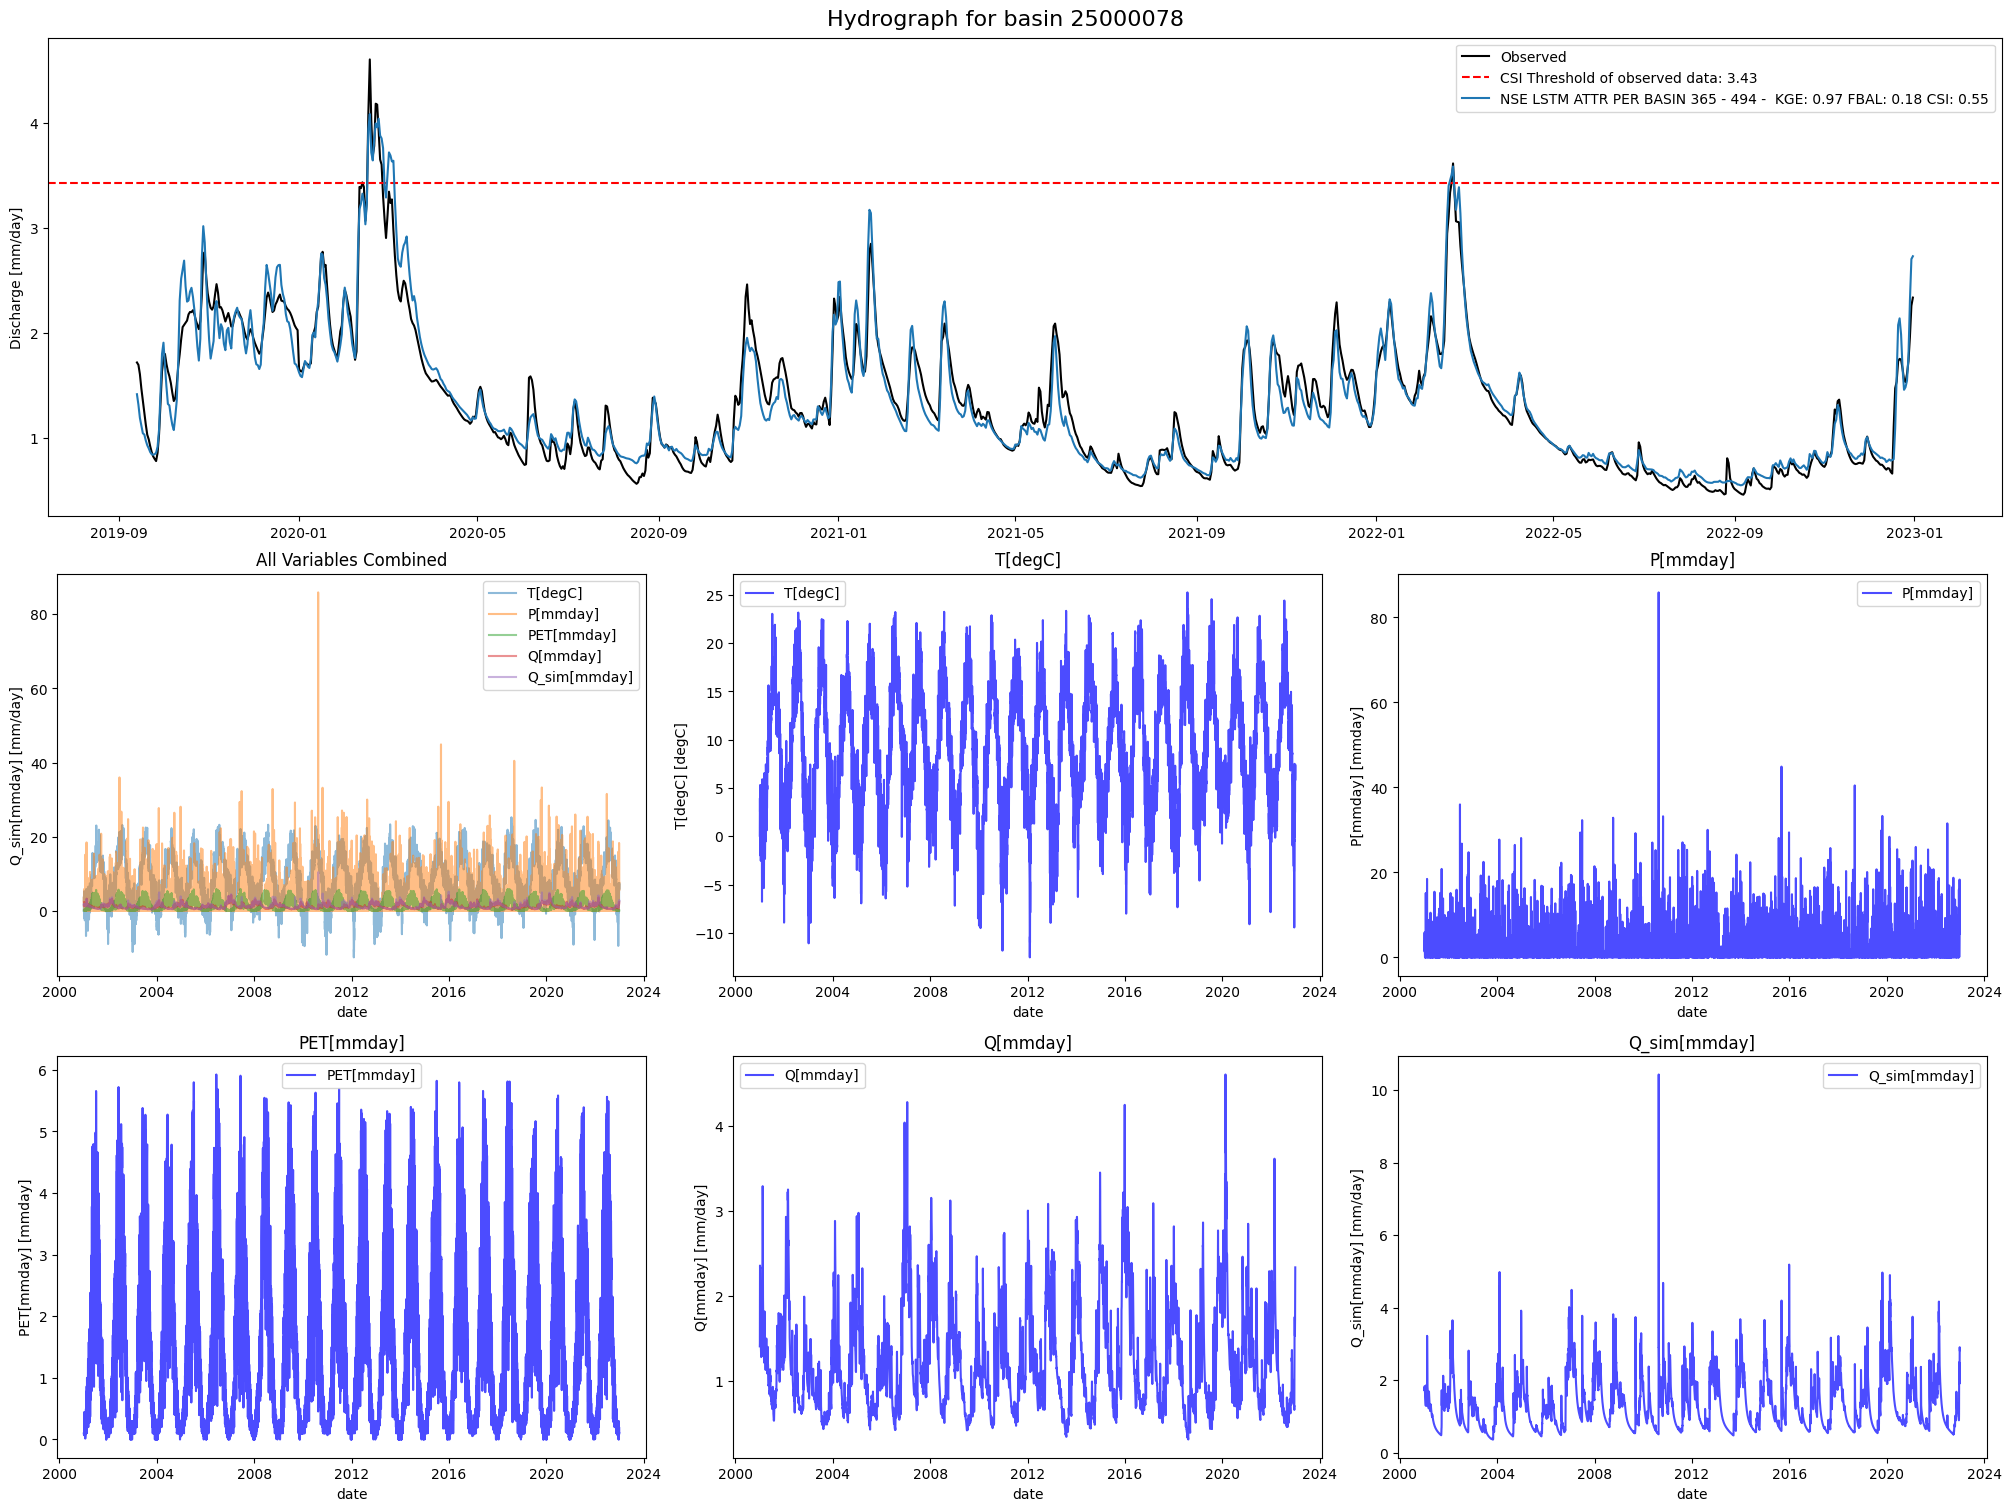

In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import scipy.stats as stats

current_run:NeuralHydrology_DKSUBSET_ModelRun = filtered_runs['NSE LSTM ATTR PER BASIN 365']#.get_metrics().copy()
current_run_df:pd.DataFrame = current_run.get_metrics().copy()

# Make a new dataframe which subtracts the two dataframes based on the basin
current_run_df.set_index('basin', inplace=True)

current_run_df.sort_values(by='KGE', inplace=True, ascending=False)
# Take the top three and bottom three basins and show the difference if the quality of the dataset is above 0.5
basins = []
i = 0
for basin in current_run_df.index:
    if i == 3:
        break   
    file = xr.open_dataset(pj(NC_FILES_FOLDER, f'{basin}.nc'))
    nc_file_dataset = file.load()
    file.close()
    quality = len(nc_file_dataset.dropna(dim='date', how='any')['date']) / len(nc_file_dataset['date'])
    
    if quality >= 0.5:
        basins.append(basin)
        i += 1
        
i = 0
for basin in current_run_df.index[::-1]:
    if i == 3:
        break   
    file = xr.open_dataset(pj(NC_FILES_FOLDER, f'{basin}.nc'))
    nc_file_dataset = file.load()
    file.close()
    quality = len(nc_file_dataset.dropna(dim='date', how='any')['date']) / len(nc_file_dataset['date'])
    
    if quality >= 0.5:
        basins.append(basin)
        i += 1
        
basins = ['25000078']
for basin in basins:
    start_date = periods_dict[basin]['start_dates'][0]
    end_date = periods_dict[basin]['end_dates'][0]
    # move startdate up by 1 month
    # start_date = start_date + pd.DateOffset(months=4)

    plt.style.use('default')

    # Create a figure with combined height
    fig = plt.figure(figsize=(20, 15), layout='constrained')
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[5, 10])

    # Load the NC File
    file = xr.open_dataset(pj(NC_FILES_FOLDER, basin + '.nc'))
    nc_file_dataset = file.load()
    file.close()

    nc_file_dataset = nc_file_dataset.sel(date=slice(start_date, end_date))
    qobs_ncfile = nc_file_dataset['Q[mmday]'].values.flatten()
    qsim_ncfile = nc_file_dataset['Q_sim[mmday]'].values.flatten()
    dates_ncfile = nc_file_dataset['date']
    
    # First subplot: Hydrograph plot
    ax1 = fig.add_subplot(gs[0])

    # Plot the observed data
    ax1.plot(dates_ncfile, qobs_ncfile, label='Observed', color='black')
    threshold = get_threshold_from_percentile(qobs_ncfile, percentile=0.01, tolerance=0.1)
    if threshold is not None:
        ax1.axhline(threshold, color='red', linestyle='--', label=f'CSI Threshold of observed data: {threshold:.2f}')
    
    unique_names = set([name.split(' ')[-1] for name, model in filtered_runs.items()])
    linestyle_counter = {x: 0 for x in unique_names}
    for label, model in filtered_runs.items():
        if ' US ' in label or 'DKHYPE' in label:
            continue
        qobs, qsim = model.get_qobs_qsim(basin)
        dates = model.nc_file_dataset[basin].sel(date=slice(start_date, end_date))['date']
        
        color = get_color_by_regex(label)
        linestyle = ['solid', 'dotted', 'dashed', 'dashdot', (0, (1,10)), (0, (5,10))]
        loss_model = label.split(' ')[-1]
        
        if threshold is not None:
            critical_success_index, n_hits, n_false, n_misses = critical_success_index_over_threshold(qsim, qobs, percentile=0.01, threshold_value=threshold, tolerance=0.1)
            # print(f'{model.label} - {basin} - CSI: {critical_success_index:.2f} - Hits: {n_hits} - False: {n_false} - Misses: {n_misses}')
        else:
             critical_success_index = -np.inf
        
        tmp_df = model.get_metrics()[model.get_metrics()['basin'] == basin]
        label = f'{model.label} - {len(model.filtered_basins)} - ' \
            f' KGE: {tmp_df['KGE'].values[0]:.2f}' \
            f' FBAL: {tmp_df['FBAL'].values[0]:.2f}' \
            f' CSI: {critical_success_index:.2f}'

        ax1.plot(dates, qsim, label=label)#, linestyle=linestyle[linestyle_counter[loss_model]], color=color, alpha=0.7)
        linestyle_counter[loss_model] += 1

    ax1.legend()
    ax1.set_ylabel('Discharge [mm/day]')
    
    # ax1.set_xlim(start_date, end_date)
    # ax1.set_ylim(min(qobs) - min(qobs) * 0.01,max(qobs) + max(qobs) * 0.01)

    
    # Load the NC File
    file = xr.open_dataset(pj(NC_FILES_FOLDER, basin + '.nc'))
    nc_file_dataset = file.load()
    file.close()

    # Second subplot: Meteorological forcings
    gs_sub = gs[1].subgridspec(2, 3)
    axes = [fig.add_subplot(gs_sub[i, j]) for i in range(2) for j in range(3)]

    variables = nc_file_dataset.data_vars

    # First subplot: combined plot of all variables
    combined_vars = [var for var in nc_file_dataset.data_vars if var in variables]
    for var in combined_vars:
            nc_file_dataset[var].plot(ax=axes[0], label=var, alpha=0.5
                                    #   , xlim=(start_date, end_date)
                                      )
    axes[0].set_title("All Variables Combined")
    axes[0].legend()

    # Individual plots for each variable
    for i, var in enumerate(variables):
        if var in nc_file_dataset.data_vars:
            nc_file_dataset[var].plot(ax=axes[i + 1], label=var, color='b', alpha=0.7)
            axes[i + 1].set_title(var)
            axes[i + 1].legend()

    t =  f'Hydrograph for basin {basin}'

    plt.suptitle(t, fontsize=16)
    plt.savefig(pj(PROJECT_FIGURES_PATH, f'hydrograph_{basin}.png'), dpi=300)
    plt.show()
    plt.close()
